In [1]:

import functools
import numpy as np
import sklearn.metrics
import sklearn.datasets
import sklearn.model_selection
import matplotlib.pyplot as plt


import pso
import ann
plt.rcParams["figure.figsize"]=(12,9)

In [2]:
def dim_weights(shape):
    dim = 0
    
    for i in range(len(shape)-1):
        dim = dim + (shape[i] + 1) * shape[i+1]
    return dim

def weights_to_vector(weights):
    w = np.asarray([])
    for i in range(len(weights)):
        v = weights[i].flatten()
        w = np.append(w, v)
    return w

def vector_to_weights(vector, shape):
    weights = []
    idx = 0
    for i in range(len(shape)-1):
        r = shape[i+1]
        c = shape[i] + 1
        idx_min = idx
        idx_max = idx + r*c
        W = vector[idx_min:idx_max].reshape(r,c)
        weights.append(W)
    return weights



#this is the optimisation for the coords of the particles??
def eval_neural_network(weights, shape, X, y,activationLayer):
    mse = np.asarray([])
    for w in weights:
        weights = vector_to_weights(w, shape)
        nn = ann.MultiLayerPerceptron(shape, weights=weights)
        y_pred = nn.run(X,activationLayer)
        #print("eval network :",y.shape,y_pred.shape,X.shape)
        mse = np.append(mse, sklearn.metrics.mean_squared_error(y, y_pred))
    return mse

def print_best_particle(best_particle):
    print("New best particle found at iteration #{i} with mean squared error: {score}".format(i=best_particle[0], score=best_particle[1]))


In [3]:
#Additional Input features
def sine(X):
    return np.sin(X)
def sq(X):
    return np.power(X,2)


In [4]:
#loading the data
num_classes = 2
f = open("two_spirals.dat","r")
data = np.loadtxt(f)
X = data[:,0:2]
y = data[:,2]
y = y.astype(int)

In [5]:
#Combines the features
def generateData(X,y,ratio,sin=False,square=False):
    if sin and square:
        X = np.hstack((X,np.hstack((sq(X),sine(X)))))
      #  print(X[0])
    elif sin:
        X=np.hstack((X,sine(X)))
    elif square:
        X = np.hstack((X,sq(X)))
    train_test_split = int(ratio*len(y))
    X_train,X_test = X[:train_test_split],X[train_test_split:]
    y_train,y_test = y[:train_test_split],y[train_test_split:]  
    print(X_train[0])
    return X_train,X_test,y_train,y_test

In [10]:
#number of iterations
iterations = 2000
#can probs put it in later
activations = ['sigmoid']#,'tanh','relu','identity']#,'relu','default']
population = 40


In [36]:
#square and sin is here for printing purposes
def train(X_train,X_test,y_train,y_test,square,sin):
    num_inputs = X_train.shape[1]
    print(f"Number of inputs = {num_inputs}")

    y_true=np.zeros((len(y_train),num_classes))
    for i in range(len(y_train)):
        y_true[i,y_train[i]] =1         #y_true[1] = [0,1], this means that 2nd index is true. and [1,0] means that 1st idx is true. can be used for more classes [0,0,0,0,1]
    
    y_test_true=np.zeros((len(y_test),num_classes))
    #same as above but for test now
    for i in range(len(y_test)):
        y_test_true[i,y_test[i]]=1

    print(f"Shapes = ({y_test_true.shape},{y_true.shape})")

    def training(shape,activationLayer,pop):
     #   print(f"Input : {X_train.shape} {y_true.shape}")
        cost_func=functools.partial(eval_neural_network,shape=shape,X=X_train, y=y_true.T, activationLayer=activationLayer)
        #chi = inertia, phi_p = alpha1, phi_g =alpha2
        swarm = pso.ParticleSwarm(cost_func, num_dimensions=dim_weights(shape), num_particles=pop,chi=0.729845 ,phi_p=2,phi_g=2)

        #train 
        i=0
        best_scores = [(i,swarm.best_score)]

        trainingLoss= []
        testLoss = []
        
        while swarm.best_score>1e-6 and i<iterations:
            swarm._update()
            i+=1
            best_weights = vector_to_weights(swarm.g,shape)
            best_nn = ann.MultiLayerPerceptron(shape,weights=best_weights)
            y_test_pred = np.round(best_nn.run(X_test,activationLayer),0)
            testError=sklearn.metrics.mean_squared_error((y_test_true.T),y_test_pred)
            trainingLoss.append(swarm.best_score)
            testLoss.append(testError)
        
        best_weights=vector_to_weights(swarm.g,shape)
        best_nn=ann.MultiLayerPerceptron(shape,weights=best_weights)
        y_test_pred = np.round(best_nn.run(X_test,activationLayer),0)
        print("Accuracy score = ",sklearn.metrics.accuracy_score(y_test_true,y_test_pred.T))

        return testLoss,y_test_pred,trainingLoss

    
    def generateTests():
        neurons=[8]#[4,5,6,7,8]
        arrays = np.zeros(shape=(len(activations),len(neurons),iterations))         #first dim = type of activation. 2nd = how many neurons and 3rd = mse at each iteration
        minError = np.inf
        yArray=[]
        trainLoss=[]
        bestParameters = np.zeros(shape=(1,1,iterations))
        for i in range(len(arrays)):
            activationLayer = activations[i]
            for k in range(len(neurons)):
                shape = (num_inputs,neurons[k],num_classes)
                mse,ys,trainError =training(shape,activationLayer,population)
                arrays[i][k] =mse
                if np.amin(mse)<minError:
                    minError = np.amin(mse)
                    yArray=ys 
                    trainLoss=trainError
                    bestParameters=[i,neurons[k],mse]
                    print(activations[i])
                print(f"Activation = {activations[i].capitalize()} neurons = {neurons[k]} with mse of {np.amin(mse)} square = {square} and sine={sin}")
        
        return arrays,yArray,bestParameters,trainError
    
    return generateTests()

    

In [37]:
X_train,X_test,y_train,y_test = generateData(X,y,0.5,True,True)    #0.5 is the train test split ratio
Combinations,testError,bestParameters,trainError = train(X_train,X_test,y_train,y_test,True,True)

# while(np.amin(bestParameters[2])>0.05):
#     Combinations,testError,bestParameters,trainError = train(X_train,X_test,y_train,y_test,True,True)


[ 4.47485    -0.89004    20.02428252  0.7921712  -0.97192002 -0.77709692]
Number of inputs = 6
Shapes = ((132, 2),(132, 2))
Accuracy score =  0.8106060606060606
sigmoid
Activation = Sigmoid neurons = 8 with mse of 0.18181818181818182 square = True and sine=True


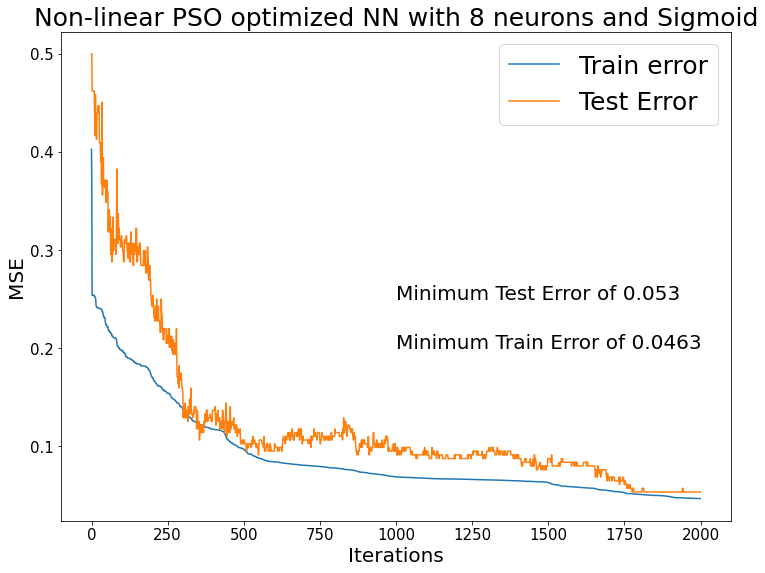

In [31]:
points = np.arange(iterations)
plt.plot(points,trainError,label="Train error")
plt.plot(points,bestParameters[2],label = "Test Error")
plt.legend(fontsize=25)
plt.text(iterations*0.5,np.amax(bestParameters[2])*0.5,f"Minimum Test Error of {np.round(np.amin(bestParameters[2]),4)}",fontsize=20)
plt.text(iterations*0.5,np.amax(bestParameters[2])*0.4,f"Minimum Train Error of {np.round(np.amin(trainError),4)}",fontsize=20)
plt.title("Non-linear PSO optimized NN with 8 neurons and Sigmoid",fontsize=25)
plt.xlabel("Iterations",fontsize=20)
plt.ylabel("MSE",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()


In [11]:
#plot the prediction and the best array?
def plotBestParameter(title,bestParameters):
    points = np.arange(iterations)
    plt.plot(points,bestParameters[2])
    plt.title(title,fontsize=25)
    plt.xlabel("Iterations",fontsize=20)
    plt.ylabel("MSE",fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.text(iterations*0.6,np.amax(bestParameters[2]),f"Minimum MSE of {np.round(np.amin(bestParameters[2]),4)}",fontsize=20)

    plt.show()
def plotPrediction(X,yArray):
    x1=[]
    x2=[]
    y1=[]
    y2=[]
    for i in range(len(yArray.T)):
        if(yArray.T[i][0]==1):
            x1.append(X[i][0])
            y1.append(X[i][1])
        else:
            x2.append(X[i][0])
            y2.append(X[i][1])
    plt.scatter(x1,y1,c="b",marker = "x",label="X")
    plt.scatter(x2,y2,c="r",marker="o",label="O")
    plt.title("Prediction values of given data (two_spirals.dat)",fontsize=25)
    plt.xlabel("X-coords",fontsize=25)
    plt.ylabel("Y-coords",fontsize=25)
    plt.legend(fontsize=25)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.savefig("../Plot_figures/test.png")  
    plt.show()

def plotting(X,y,square,sin):
    inputs = 2
    if square:
        inputs+=2
    if sin:
        inputs+=2
    X_train,X_test,y_train,y_test = generateData(X,y,0.5,square,sin)    #0.5 is the train test split ratio
    allParameters,prediction,bestParameters = train(X_train,X_test,y_train,y_test,square,sin)          #best parameters is used to plot the predictions ##allParameters to plot everything
    #plot best parameter
    print(prediction.shape,X_train.shape)
    title = f"Activation:{activations[bestParameters[0]]} Neurons={bestParameters[1]} and inputs = {inputs}"
    plotBestParameter(title,bestParameters)
    plotPrediction(X,prediction)



[ 4.47485 -0.89004]
Number of inputs = 2
Shapes = ((132, 2),(132, 2))
sigmoid
Activation = Sigmoid neurons = 4 with mse of 0.42803030303030304 square = False and sine=False
Activation = Sigmoid neurons = 5 with mse of 0.4621212121212121 square = False and sine=False
Activation = Sigmoid neurons = 6 with mse of 0.4431818181818182 square = False and sine=False
sigmoid
Activation = Sigmoid neurons = 7 with mse of 0.4166666666666667 square = False and sine=False
Activation = Sigmoid neurons = 8 with mse of 0.4393939393939394 square = False and sine=False
(2, 132) (132, 2)


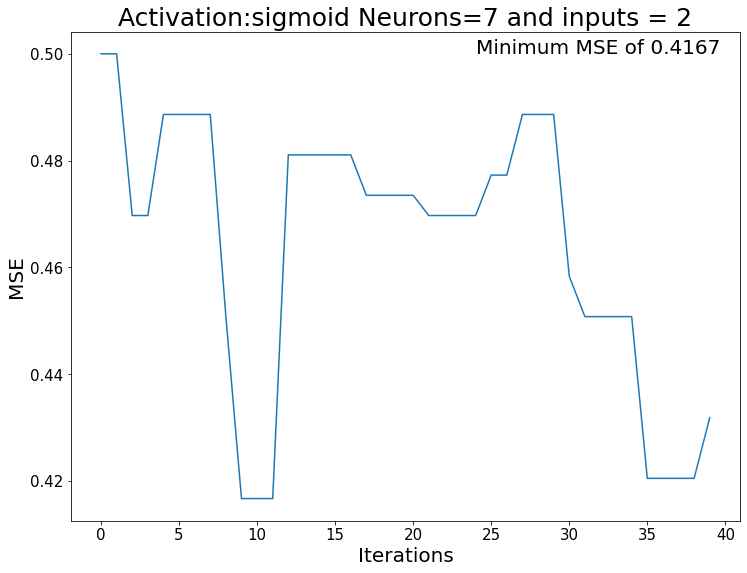

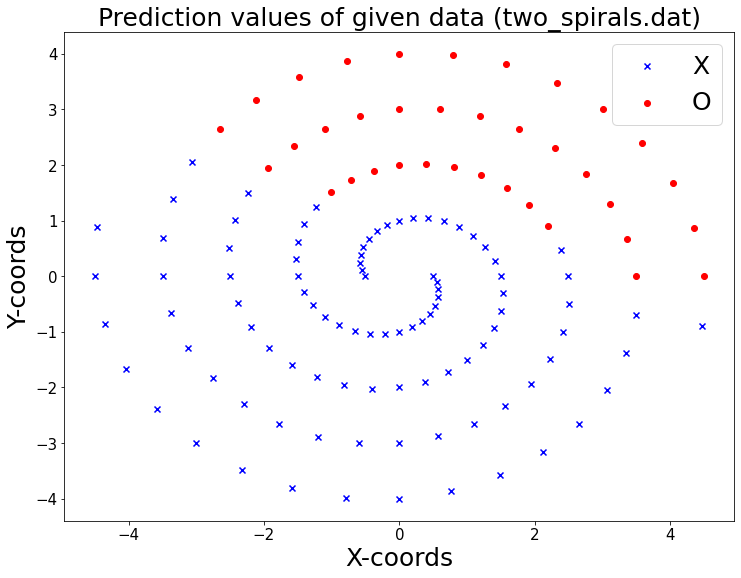

In [55]:
plotting(X,y,False,False)
# plotting(X,y,True,False)
# plotting(X,y,False,True)
# plotting(X,y,True,True)